## 1. Limpeza dos Dados
---

Primeiro vamos importar as bibliotecas a serem usadas, declarar o conjunto de dados no qual trabalharemos e fazer uma rápida limpeza.

Devemos verificar se há incongruências na estruturação dos dados, se existe alguma falha na extração original, etc.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Importa bibliotecas Pandas (manipulação de dados), Seaborn (visualização de dados) e Matplot (customização de visualização)

notas = pd.read_csv("dados_extraidos.csv")
# Lê o arquivo CSV e atribui a um dataframe com nome "notas"
notas.head()
# Exibe as 5 primeiras linhas do dataframe, para garantir que está tudo certo.

,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
0,DO CPF,NOME,MAT.,FIS.,QUIM.,INGL.,MEDIA,NaN
1,653-19,ABEL DE MATOS OLIVEIRA MARQUES,"6,6666","6,6666","9,1666","5,0000","7,5000",NaN
2,233-05,ABEL DUARTE BRANDAO,"7,5000","5,0000","9,1666","5,8333","7,2222",NaN
3,894-14,ABIGAIL AMARAL LIMA,"5,8333","4,1666","6,6666","5,8333","5,5555",NaN
4,305-14,ABILER KAUAN SANTANA LIMA SILVA,"4,1666","1,6666","3,3333","5,0000","3,0555",NaN


### Estruturação dos dados
O script de raspagem capturou o cabeçalho da tabela como primeira linha, algo que deve ser corrigido. além disso, as variáveis quantitativas contínuas estão usando ",", ao invés de ".", portanto podem estar sendo interpretadas como string, algo que devemos verificar.

In [3]:
notas = notas.drop(index=0)
# Pedir para ignorar a primeira linha do dataframe que, pelo script de raspagem, acabou copiando o cabeçalho.

notas.info()
# Para analisar se o dataframe está funcional, puxa-se as informações.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9780 entries, 1 to 9780
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   final_CPF  9780 non-null   object 
 1   nome       9780 non-null   object 
 2   nota_Mat   9780 non-null   object 
 3   nota_Fis   9780 non-null   object 
 4   nota_Qui   9780 non-null   object 
 5   nota_Ing   9780 non-null   object 
 6   media      9780 non-null   object 
 7   presenca   0 non-null      float64
dtypes: float64(1), object(7)
memory usage: 611.4+ KB


De fato, as colunas de notas e médias não estão sendo interpretadas como numéricas. Para isso, basta passar um comando que substitua o caractere utilizado.

Além disso, a coluna"presenca", que deveria indicar se o candidato compareceu ou não à prova, não foi lida corretamente. Vamos transformar essa variável em booleana, adotando valor "False" quando a média for atribuída a zero e "True" em todos os outros casos.

In [4]:
colunas_para_converter = ['nota_Mat', 'nota_Fis', 'nota_Qui', 'nota_Ing', 'media']
# Cria um array com os nomes das colunas que estão sendo lidas como tipos errados de variável.
notas[colunas_para_converter] = notas[colunas_para_converter].replace(',', '.', regex=True).astype(float)
# Substitui a "," por "." e define o tipo de variável como "float".

notas['presenca'] = notas['media'] != 0
# Atribui variável booleana à coluna presença, e verifica a presença a partir da média ser nula

notas.head()


,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
1,653-19,ABEL DE MATOS OLIVEIRA MARQUES,6.6666,6.6666,9.1666,5.0000,7.5000,True
2,233-05,ABEL DUARTE BRANDAO,7.5000,5.0000,9.1666,5.8333,7.2222,True
3,894-14,ABIGAIL AMARAL LIMA,5.8333,4.1666,6.6666,5.8333,5.5555,True
4,305-14,ABILER KAUAN SANTANA LIMA SILVA,4.1666,1.6666,3.3333,5.0000,3.0555,True
5,992-67,ABNER AUGUSTO DE ALMEIDA SILVA,0.0000,0.0000,0.0000,0.0000,0.0000,False


## 2. Visualização inicial dos dados
---

Com os dados organizados e estruturados, vamos começar a explorar o dataframe. O objetivo agora é gerar insights a partir de visualizações gráficas desses dados, a partir de histogramas simplificados.

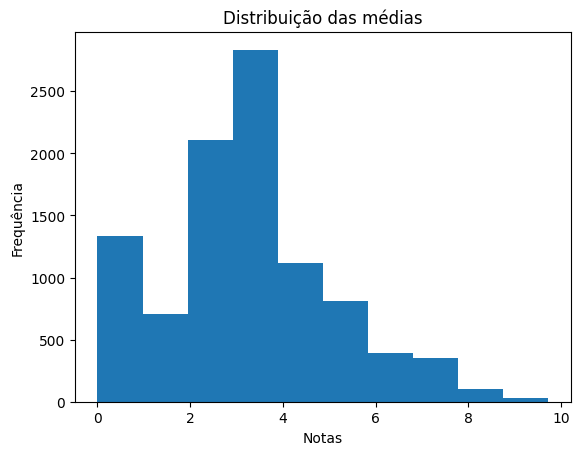

In [30]:
notas["media"].plot(kind='hist')
# Cria um histograma simplificado da variável "media"
plt.title('Distribuição das médias')
plt.xlabel('Notas')
plt.ylabel('Frequência')
plt.show()

### Primeira interpretação
Observa-se, na distribuição das médias dos candidatos, dois picos: um entre 0 e 1; outro entre 3 e 4.

O mais esperado é que a distribuição tivesse apenas um pico, sugerindo alguma anomalia nos dados. Possivelmente, um número considerável de candidatos faltou, gerando essa distorção. Corrigiremos a seguir.

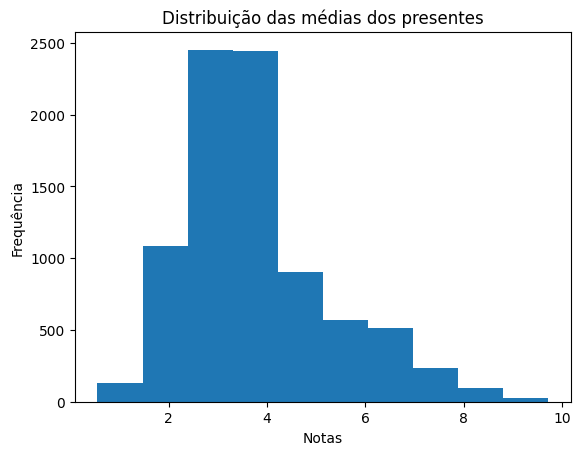

In [31]:
notas_presentes = notas.query("presenca == True")
# Busca apenas as linhas em que o candidato esteve presente à prova

notas_presentes["media"].plot(kind='hist')
plt.title('Distribuição das médias dos presentes')
plt.xlabel('Notas')
plt.ylabel('Frequência')
plt.show()

### Visualização em Boxplot
Podemos, ainda, fazer uma rápida visualização dessa distribuição através de um Boxplot, a fim de observar o comportamento da variável.

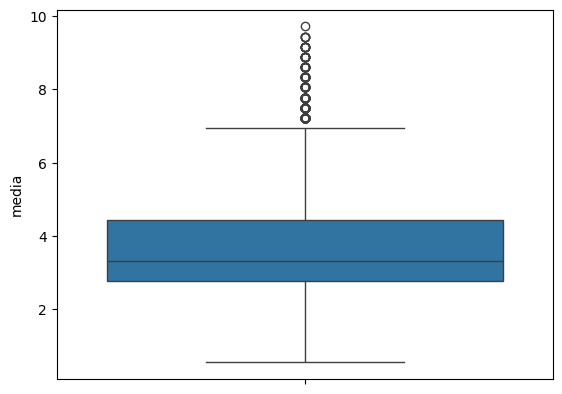

In [7]:
sns.boxplot(notas_presentes["media"])
plt.show()

De fato, é visível a informação de que mais da metade dos candidatos presentes obtiveram nota inferior a 3,5000.

### Ranking de notas
Podemos já extrair o ranking de notas. Tendo em vista que pelo menos 600 candidatos devem ser chamados para a segunda fase, é possível calcularmos também a nota de corte.

Primeiro, vamos limpar da nossa lista todos os candidatos que obtiveram nota inferior ao mínimo previsto em edital para cada matéria. Assim, apenas os candidatos com todas as notas maiores ou iguais a 4,1666 serão considerados válidos.

In [8]:
notas_validas = notas_presentes[
    (notas_presentes['nota_Mat'] >= 4.1666) &
    (notas_presentes['nota_Fis'] >= 4.1666) &
    (notas_presentes['nota_Qui'] >= 4.1666) &
    (notas_presentes['nota_Ing'] >= 4.1666)
]
# Seleciona apenas os candidatos com notas iguais ou maiores do que o mínimo em cada matéria.

notas_validas_ordenadas = notas_validas.sort_values(by=['media', 'nota_Mat', 'nota_Fis', 'nota_Qui'], ascending=False)
notas_validas_ordenadas.tail()
# Ordena os dados em ordem descrescente na variável "media", usando os critérios de desempate previstos em edital, e imprime o final da lista para verificar se está funcionando


,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
8134,203-46,PEDRO PAULO DENIZART DOS SANTOS,4.1666,4.1666,4.1666,4.1666,4.1666,True
8627,468-31,ROBERTO NORIO KUBO,4.1666,4.1666,4.1666,6.6666,4.1666,True
8664,557-79,ROGER BONOW MENDES NETO,4.1666,4.1666,4.1666,5.8333,4.1666,True
9023,444-77,TAYANE THARCILLA FISCHER VIEIRA,4.1666,4.1666,4.1666,7.5000,4.1666,True
9214,411-60,TIAGO RABELO CAMARGOS,4.1666,4.1666,4.1666,9.1666,4.1666,True


Agora podemos descobrir qual foi a nota de corte, bem como descobrir quantos candidatos, no total, atingiram nota satisfatória para prosseguir para a segunda fase.

In [9]:
nota_de_corte = notas_validas_ordenadas.iloc[600]['media']
# Define a varável "nota_de_corte" como sendo o valor de "media" para o 600º elemento na ordenação.

print(f"A nota de corte para os 600 primeiros colocados é: {nota_de_corte}")

A nota de corte para os 600 primeiros colocados é: 6.3888


In [10]:
numero_aprovados = notas_validas_ordenadas.query("media >= @nota_de_corte").count()["nome"]

print(f"O número de candidatos com nota suficiente para serem aprovados para a segunda fase foi de {numero_aprovados} candidatos")

O número de candidatos com nota suficiente para serem aprovados para a segunda fase foi de 711 candidatos


In [11]:
notas_aprovados = notas_validas_ordenadas.query("media >= @nota_de_corte")
notas_aprovados.head(10)

,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
4014,111-67,IAN VASCONCELOS LOTUFO,9.1666,10.0000,10.0000,8.3333,9.7222,True
4565,146-78,JOAO MIGUEL COSTA SANTANA SODRE MENDES,10.0000,9.1666,9.1666,8.3333,9.4444,True
1499,310-84,CAUA VANDERLEY LOPES FURTADO,10.0000,8.3333,10.0000,5.8333,9.4444,True
4734,986-24,JOAO PEDRO PENNA SALES,9.1666,9.1666,10.0000,9.1666,9.4444,True
5533,386-40,LEONARDO CORDEIRO SILVA,9.1666,9.1666,10.0000,8.3333,9.4444,True
1711,493-39,DANTE PORTO RODRIGUES,10.0000,8.3333,9.1666,6.6666,9.1666,True
5609,566-95,LEONARDO TORRES SILVA,10.0000,8.3333,9.1666,8.3333,9.1666,True
400,881-24,ANASTASSIOS DIONYSSIOS KLAVDIANOS TAVARES,10.0000,7.5000,10.0000,7.5000,9.1666,True
1151,486-62,BRUNO FERREIRA PARREIRA,10.0000,7.5000,10.0000,7.5000,9.1666,True
629,277-63,ARTHUR AMARAL ARRAES HENRIQUE,9.1666,9.1666,9.1666,10.0000,9.1666,True


Foi possível aferir o top 10 de notas, bem como a nota de corte para um mínimo de 600 convocados para a fase seguinte.

Para efeitos de cálculo e análise, só foram feitas considerações para o que o edital previa para os candidatos da Ampla Concorrência, já que o dataframe coletado não discrimina quais candidatos da lista são cotistas.

Apesar dessa diferença, a nota de corte calculada aqui foi a mesma informada no site do vestibular.

## 3. Estatística Descritiva
---

Agora que os dados estão devidamente filtrados e que temos uma visualização inicial, podemos extrair informações mais profundas do conjunto de dados, como a média e a mediana em cada matéria, bem como as medidas de dispersão de cada conjunto.

Podemos criar rankings baseados em cada matéria, além de verificar as correlações entre as notas de cada matéria e a média final.

### Overview das estatísticas
Vamos começar a seguir fazendo uma rápida visualização das distribuições das notas em cada matéria, através de gráficos boxplot.

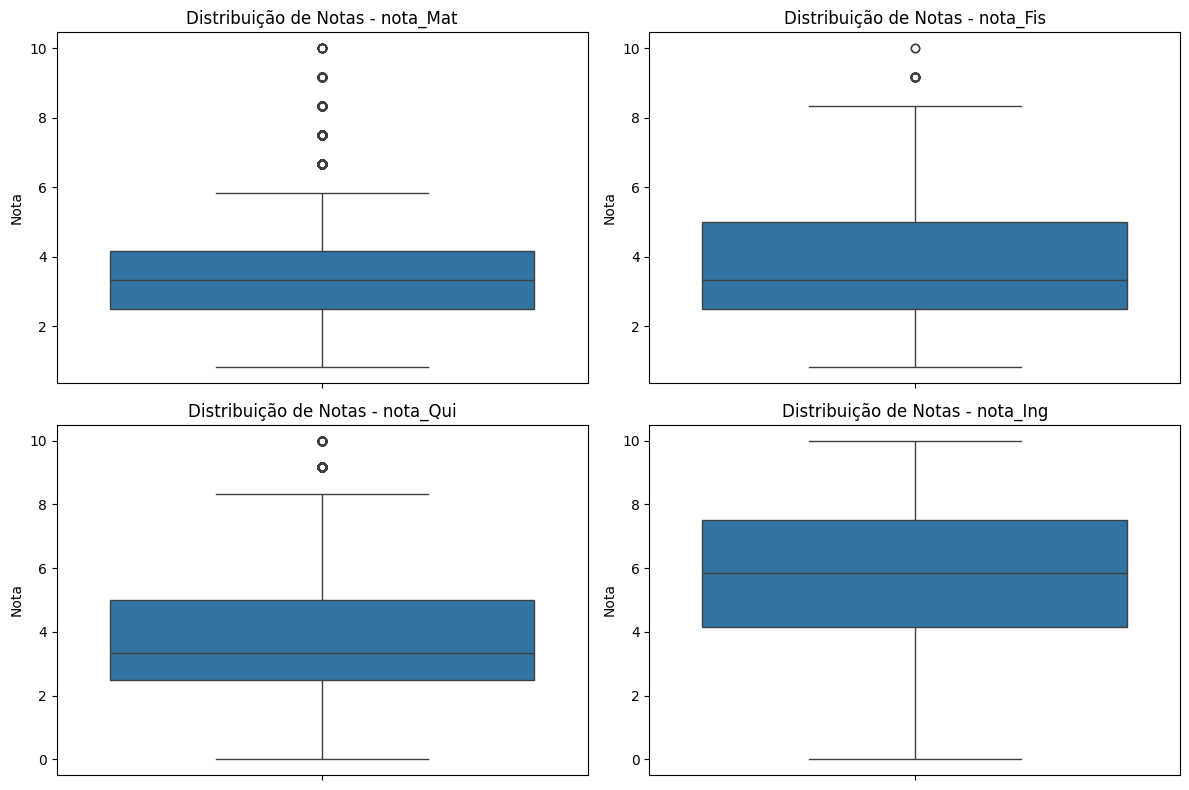

In [12]:
# Crie uma figura com 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Lista das matérias
materias = ['nota_Mat', 'nota_Fis', 'nota_Qui', 'nota_Ing']

# Itere pelas matérias e crie um boxplot para cada uma
for i, materia in enumerate(materias):
    row = i // 2
    col = i % 2
    sns.boxplot(y=notas_presentes[materia], ax=axes[row, col])
    axes[row, col].set_title(f'Distribuição de Notas - {materia}')
    axes[row, col].set_ylabel('Nota')

# Ajuste o layout para evitar sobreposição
plt.tight_layout()

# Exiba a figura
plt.show()

Pela visualização, podemos levantar 3 hipóteses:
1. A prova de matemátiva parece ter sido a mais difícil.
2. As provas de Física e de Química tiveram uma distribuição similar, indicando que estavam um pouco menos complicadas do que a de Matemática.
3. A prova de inglês apresentou a maior média, que ultrapassa inclusive a nota de corte, indicando ter sido a mais fácil, mesmo que alguns candidatos a tenham zerado.

Para aprofundarmos essa análise, podemos puxar as estatísticas descritivas de cada conjunto de dados.

In [13]:
estatisticas_descritivas = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], columns=materias)
# Cria um dataframe vazio para armazenar as estatísticas descritivas

for materia in materias:
    estatisticas_descritivas[materia] = notas_presentes[materia].describe()
# Utiliza loop para preencher o DataFrame com as respostas do .describe()

estatisticas_descritivas

,nota_Mat,nota_Fis,nota_Qui,nota_Ing
count,8465.000000,8465.000000,8465.000000,8465.000000
mean,3.535899,3.746473,3.971418,5.704042
std,1.685749,1.688482,2.155159,2.168648
min,0.833300,0.833300,0.000000,0.000000
25%,2.500000,2.500000,2.500000,4.166600
50%,3.333300,3.333300,3.333300,5.833300
75%,4.166600,5.000000,5.000000,7.500000
max,10.000000,10.000000,10.000000,10.000000


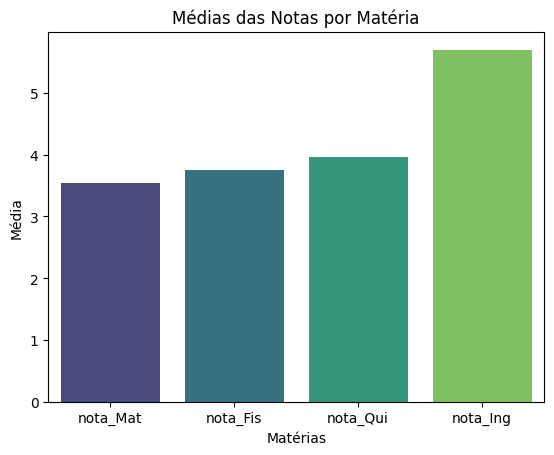

In [14]:
sns.barplot(
    x=estatisticas_descritivas.columns,
    hue=estatisticas_descritivas.columns,
    y=estatisticas_descritivas.loc['mean'],
    palette='viridis'
    )
# Cria a visualização em barras das médias de cada matéria, diferenciando-as por cores, para facilitar a análise

plt.title('Médias das Notas por Matéria')
plt.xlabel('Matérias')
plt.ylabel('Média')
# Aplica títulos ao gráfico, para facilitar a leitura

plt.show()

Pode-se observar que as médias em cada matéria de exatas se mantém entre 3,5 e 4,0, enquanto a média de inglês é consideravelmente maior, ultrapassando 5,7. Isso pode indicar que, na média, a prova de inglês foi mais fácil do que as demais. Entretanto, existem outras medidas que valem a pena se observar.

Quando maior o valor da variável "std", ou seja, o desvio padrão em torno da média, mais dispersos são os dados.

Isso indica que as notas de Química e de Inglês foram bem menos regulares do que Matemática e Física, ainda que existam canidatos com nota 10 em cada matéria, mesmo que ninguém tenha obtido nota máxima em todas ao mesmo tempo.

Para entendermos melhor esse fenômenos, podemos analisar isoladamente as distribuições por histogramas para cada matéria.

### Aprofundando nas estatísticas de cada prova

#### Matemática
A informação mais expressiva sobre a prova de matemática deve ser o fato de que **75% dos candidatos** obtiveram nota **menor ou igual ao mínimo**.

Vamos calulcar a seguir a porcentagem exata de candidatos que não atingiram o perfil:

In [15]:
total_candidatos = len(notas_presentes)
# Calcula o total de candidatos presentes na 1ª fase

cortados_mat = notas_presentes.query("nota_Mat < 4.1666").shape[0]
# Calcula a quantidade de alunos com nota menor do que a mínima

porcentagem_cortados_mat = (cortados_mat / total_candidatos) * 100
# Calcula a porcentagem, por razão simples

print(f"Porcentagem de candidatos com nota abaixo do corte: {porcentagem_cortados_mat:.2f}%")

Porcentagem de candidatos com nota abaixo do corte: 62.13%


Descobrimos que *62,13%* dos candidatos que compareceram à prova foram eliminados em Matemática, mostrando como essa foi uma prova decisiva para determinar quem passaria para a próxima fase.

Vejamos a seguir outras visualizações relevantes e estatísticas que nos ajudem a compreender o comportamento das notas de matemática.

<Axes: ylabel='Frequency'>

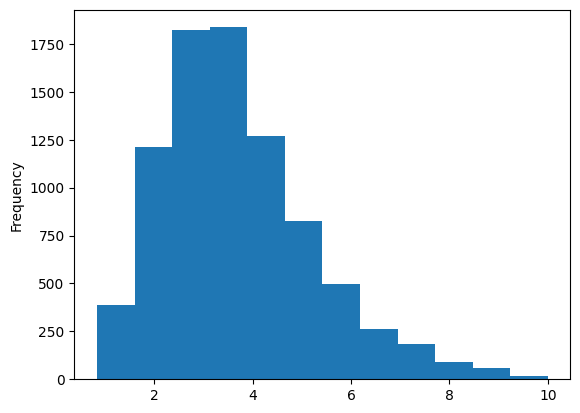

In [16]:
notas_presentes["nota_Mat"].plot(kind='hist', bins=12)

In [17]:
notas_presentes["nota_Mat"].median()

3.3333

O histograma que apresenta a distribuição das notas de matemática mostra como a maior parte das notas está, de fato, concentrada abaixo da nota de corte, 4,1666.

Além disso, calculamos a mediana das notas de matemática como sendo de *3,3333*, mostrando mais uma vez que mais da metade dos candidatos não atingiram o perfil mínimo exigido pelo edital na prova de matemática.

Podemos também visualizar o ranking apenas das notasd e matemática:

In [18]:
notas_presentes_ordenadas_Mat = notas_presentes.sort_values(by=['nota_Mat', 'media', 'nota_Fis'], ascending=False)
print("Aqui está a classificação dos candidatos tomando como base a nota de Matenática:\n")
notas_presentes_ordenadas_Mat

Aqui está a classificação dos candidatos tomando como base a nota de Matenática:



,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
4565,146-78,JOAO MIGUEL COSTA SANTANA SODRE MENDES,10.0000,9.1666,9.1666,8.3333,9.4444,True
1499,310-84,CAUA VANDERLEY LOPES FURTADO,10.0000,8.3333,10.0000,5.8333,9.4444,True
1711,493-39,DANTE PORTO RODRIGUES,10.0000,8.3333,9.1666,6.6666,9.1666,True
5609,566-95,LEONARDO TORRES SILVA,10.0000,8.3333,9.1666,8.3333,9.1666,True
400,881-24,ANASTASSIOS DIONYSSIOS KLAVDIANOS TAVARES,10.0000,7.5000,10.0000,7.5000,9.1666,True
...,...,...,...,...,...,...,...,...
6572,455-19,MARCOS PAULO GUIMARAES DE CARVALHO FILHO,0.8333,0.8333,0.0000,0.0000,0.5555,True
8146,787-64,PEDRO PONTES DOS ANJOS COUTINHO,0.8333,0.8333,0.0000,2.5000,0.5555,True
8411,550-25,RAIANE ARCARO DAROS,0.8333,0.8333,0.0000,0.0000,0.5555,True
8740,952-01,SALIM ABINADER FRANCO,0.8333,0.8333,0.0000,0.0000,0.5555,True


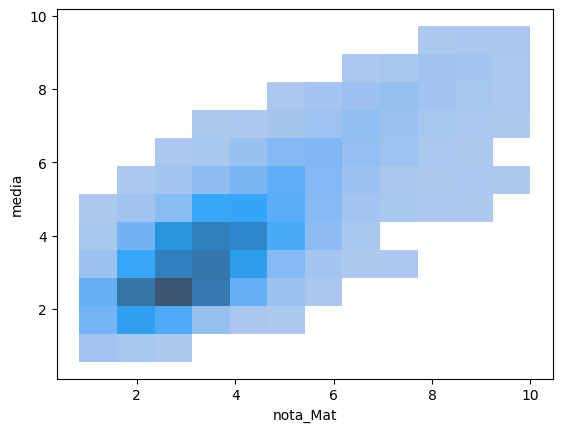


 A medida da correlação entre a nota de matemática e a média é:  0.779395


In [19]:
sns.histplot(notas_presentes, x="nota_Mat", y="media", bins = 12)
plt.show()
corr_Mat = notas_presentes['nota_Mat'].corr(notas_presentes['media'])
print(f"\n A medida da correlação entre a nota de matemática e a média é: {corr_Mat: 3f}")

Por fim, criamos um gráfico que relaciona as notas de matemática com as médias dos candidatos, a fim de visualizar o quanto a nota de matemática parece influenciar na média final em termos de correlação.

Calulamos ainda o valor dessa correlação, chegando a *0,779395*

#### Física

Aprova de física pareceu oferecer mais oportunidades do que a de matemática, ainda que menos do que 25% dos candidatos tenha acertado mais da metade das questões e que mais da metade não tenha atingido a nota mínima de corte.

In [20]:
cortados_fis = notas_presentes.query("nota_Fis < 4.1666").shape[0]
# Calcula a quantidade de alunos com nota menor do que a mínima

porcentagem_cortados_fis = (cortados_fis / total_candidatos) * 100
# Calcula a porcentagem, por razão simples

print(f"Porcentagem de candidatos com nota abaixo do corte: {porcentagem_cortados_fis:.2f}%")

Porcentagem de candidatos com nota abaixo do corte: 56.08%


*56,08%* dos candidatos presentes não alcançaram o perfil mínimo em física e foram eliminados na prova devido essa nota. Apesar de uma porcentagem um pouco menor do que a prova de matemática, isso mostra que, aidna que a média tenha sido mais alta, a prova de física não pôde ser considerada "fácil".

<Axes: ylabel='Frequency'>

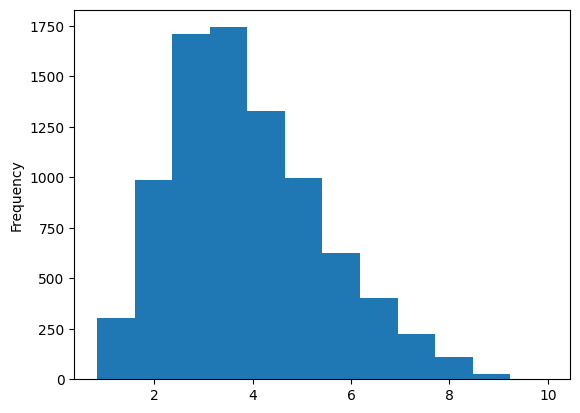

In [21]:
notas_presentes["nota_Fis"].plot(kind='hist', bins=12)

In [22]:
notas_presentes["nota_Fis"].median()

3.3333

O histograma que representa a distribuição das notas de física mostra uma dispersão um pouco maior do que o gráfico para matemática, com mais notas acima da média.

Além disso, o valor da mediana, como estava previsto, é inferior ao perfil mínimo, indicando mais uma vez que mais da metade dos candidatos presentes não atingiu a nota de corte.

Ordenando o DataFrame, obtemos o ranking para a nota de física:

In [23]:
notas_presentes_ordenadas_Fis = notas_presentes.sort_values(by=['nota_Fis', 'media', 'nota_Mat'], ascending=False)
print("Aqui está a classificação dos candidatos tomando como base a nota de Física:\n")
notas_presentes_ordenadas_Fis

Aqui está a classificação dos candidatos tomando como base a nota de Física:



,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
4014,111-67,IAN VASCONCELOS LOTUFO,9.1666,10.0000,10.0000,8.3333,9.7222,True
7492,498-08,NATAN PEPELIASCOV,8.3333,10.0000,8.3333,6.6666,8.8888,True
4565,146-78,JOAO MIGUEL COSTA SANTANA SODRE MENDES,10.0000,9.1666,9.1666,8.3333,9.4444,True
4734,986-24,JOAO PEDRO PENNA SALES,9.1666,9.1666,10.0000,9.1666,9.4444,True
5533,386-40,LEONARDO CORDEIRO SILVA,9.1666,9.1666,10.0000,8.3333,9.4444,True
...,...,...,...,...,...,...,...,...
6572,455-19,MARCOS PAULO GUIMARAES DE CARVALHO FILHO,0.8333,0.8333,0.0000,0.0000,0.5555,True
8146,787-64,PEDRO PONTES DOS ANJOS COUTINHO,0.8333,0.8333,0.0000,2.5000,0.5555,True
8411,550-25,RAIANE ARCARO DAROS,0.8333,0.8333,0.0000,0.0000,0.5555,True
8740,952-01,SALIM ABINADER FRANCO,0.8333,0.8333,0.0000,0.0000,0.5555,True


Por fim, podemos analisar que a correlação entre as notas de física e de média foi um pouco maior do que o mesmo valor para matemática, sugerindo que a prova de matemática foi mais destoante em relação à realidade do vestibular como um todo.

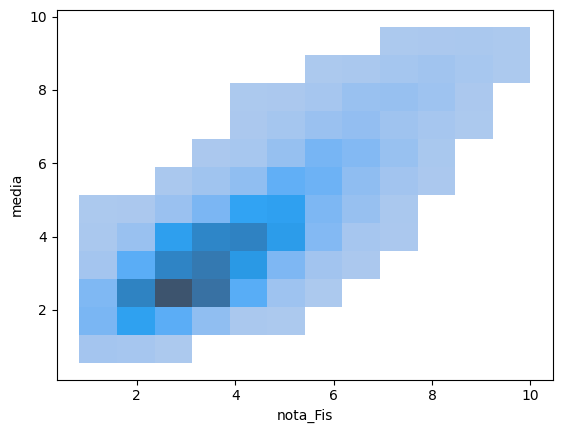


 A medida da correlação entre a nota de física e a média é:  0.811238


In [24]:
sns.histplot(notas_presentes, x="nota_Fis", y="media", bins = 12)
plt.show()
corr_Fis = notas_presentes['nota_Fis'].corr(notas_presentes['media'])
print(f"\n A medida da correlação entre a nota de física e a média é: {corr_Fis: 3f}")

#### Química

Repetindo o mesmo procedimento para a prova de química, obtivemos resultados similares. Os gráficos ilustram uma diferença importante: foi a única prova entre as 3 exatas em que houve nota 0, ainda que tenha sido uma prova estatisticamente mais fácil do que as outras duas.

A porcentagem de candidatos que compareceram à prova e foram cortados em química é de *52,66%*

O gráfico de distribuição mostra uma quantidade ainda maior de notas altas em relação à prova de física e de matemática, apresentando o mesmo valor de mediana ( *3,3333* ).

A correlação entre as notas de química e as médias foi ainda maior do que na prova de física, indicando que essa foi um prova que melhor avaliou os conhecimentos esperados pelo vestibular, ainda que os valores de correlações para cada matéria não tenha sido muito diferentes entre si.

In [25]:
cortados_qui = notas_presentes.query("nota_Qui < 4.1666").shape[0]
# Calcula a quantidade de alunos com nota menor do que a mínima

porcentagem_cortados_qui = (cortados_qui / total_candidatos) * 100
# Calcula a porcentagem, por razão simples

print(f"Porcentagem de candidatos com nota abaixo do corte: {porcentagem_cortados_qui:.2f}%")

Porcentagem de candidatos com nota abaixo do corte: 52.66%


<Axes: ylabel='Frequency'>

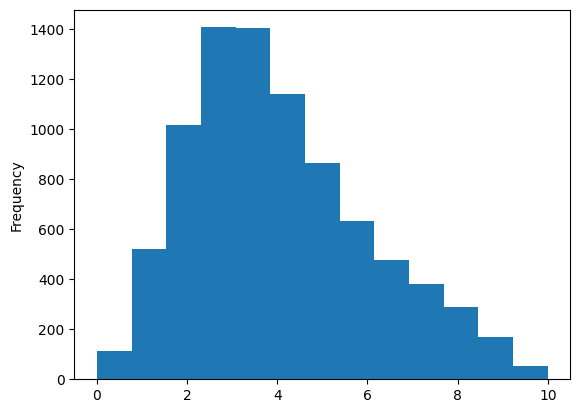

In [26]:
notas_presentes["nota_Qui"].plot(kind='hist', bins=13)

In [27]:
notas_presentes["nota_Qui"].median()

3.3333

In [28]:
notas_presentes_ordenadas_Qui = notas_presentes.sort_values(by=['nota_Qui', 'media', 'nota_Mat'], ascending=False)
print("Aqui está a classificação dos candidatos tomando como base a nota de Química:\n")
notas_presentes_ordenadas_Qui

Aqui está a classificação dos candidatos tomando como base a nota de Química:



,final_CPF,nome,nota_Mat,nota_Fis,nota_Qui,nota_Ing,media,presenca
4014,111-67,IAN VASCONCELOS LOTUFO,9.1666,10.0000,10.0,8.3333,9.7222,True
1499,310-84,CAUA VANDERLEY LOPES FURTADO,10.0000,8.3333,10.0,5.8333,9.4444,True
4734,986-24,JOAO PEDRO PENNA SALES,9.1666,9.1666,10.0,9.1666,9.4444,True
5533,386-40,LEONARDO CORDEIRO SILVA,9.1666,9.1666,10.0,8.3333,9.4444,True
400,881-24,ANASTASSIOS DIONYSSIOS KLAVDIANOS TAVARES,10.0000,7.5000,10.0,7.5000,9.1666,True
...,...,...,...,...,...,...,...,...
6572,455-19,MARCOS PAULO GUIMARAES DE CARVALHO FILHO,0.8333,0.8333,0.0,0.0000,0.5555,True
8146,787-64,PEDRO PONTES DOS ANJOS COUTINHO,0.8333,0.8333,0.0,2.5000,0.5555,True
8411,550-25,RAIANE ARCARO DAROS,0.8333,0.8333,0.0,0.0000,0.5555,True
8740,952-01,SALIM ABINADER FRANCO,0.8333,0.8333,0.0,0.0000,0.5555,True


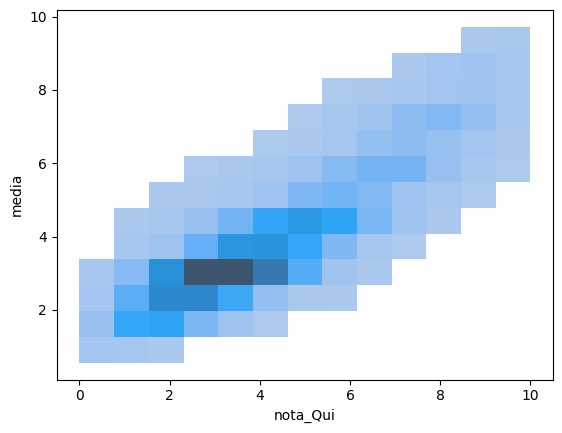


 A medida da correlação entre a nota de matemática e a média é: 0.86509429685263


In [29]:
sns.histplot(notas_presentes, x="nota_Qui", y="media", bins = 13)
plt.show()
corr_Qui = notas_presentes['nota_Qui'].corr(notas_presentes['media'])
print(f"\n A medida da correlação entre a nota de matemática e a média é: {corr_Qui}")